# Assignment No 3a
### *Written By: Sibt ul Hussain*
----
## Goal

Your goal in this assigment is to implement a KNN Classifier.

**Note** Please note that you are allowed to use only those libraries which we have discussed in the class, i.e. numpy, scipy, pandas.


## Submission Instructions
You are required to submit the original notebook file on the Slate (with .ipynb extension), with complete set of outputs. Students failing to do so will get zero marks. 

**Please read each step carefully and understand it fully before proceeding with code writing**

## Plagiarism
Any form of plagiarism will not be tolerated and result in 0 marks.


Lets suppose there are $m$ examples of size $d$, which are stored in a training matrix $D$ of size $m \times d$. Now if we use Euclidean distance for the finding the best match for a given test example  $q_{d\times1}$ how many multiplications and additions we will need to perform ?

Here you will be implementing three versions of KNN classifiers, those are:
 1. Using two nested loops, i.e. for a given example you will have to compute its L2 distance with all the training samples, thus you will need to implement it using two nested loops...**Please first complete the assignment using this method and then go for further optimizations mentioned in step 2 and 3**
 2. Using one loop, i.e. you can get rid of one loop using the numpy vectorization (tiling the test example).
 3. The number of multiplications and additions can be reduced a lot if we use an alternate definition of Euclidean distance, i.e. $$||x-y||^2=||x||^2+||y||^2-2x^Ty$$
instead of using the traditional definition $$||x-y||^2=\sum_i (x_i-y_i)^2$$ This definition will help you to implement a very fast version of KNN classifier without using any loop whatsoever. 

#### HelpFul Functions
You might find following functions to be extremely helpful
 - **[argpartition] (http://docs.scipy.org/doc/numpy/reference/generated/numpy.argpartition.html)** uses introselect algorithm to perform an indirect partition along the given axis. This can lead to O(n) complexity instead of O(nlogn). Remember indexing start from 0.
 - **[itemfreq]()** a function that returns a 2-D array of item frequencies.

### K Nearest Neighbour Classifier

Now in this assignment we will be implementing the K Nearest Neighbour Classifier for Continuous attributes.


In [1]:
%pylab inline
import scipy.stats
from collections import defaultdict
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload 
%autoreload 2
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# TODO: You have to implement the following class
## Your code goes here...

class KNearestNeighbor:
    ''' Implements the KNearest Neigbours For Classification... '''
    def __init__(self, k, scalefeatures=False):        
        self.k=k
        self.scalefeatures=scalefeatures
        self.X_train=[]
        self.Y_train=[]
        self.class_freq=[]
        self.mydict={}
        
        #pass    
    
    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the 
        test data.

        Input:
        X - An num_test x dimension array where each row is a test point.

        Output:
        dists - A num_test x num_train array where dists[i, j] is the distance
                between the ith test point and the jth training point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
            for j in xrange(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]               #
                #####################################################################
                # YOUR CODE HERE
                dists[i,j]=scipy.spatial.distance.euclidean(X[i],self.X_train[j])
                # Or
#                 dists[i,j]=np.linalg.norm(X[i]-self.X_train[j])

                #####################################################################
                #                       END OF YOUR CODE                            #
                #####################################################################
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            #######################################################################
            # YOUR CODE HERE
            dists[i,:]=np.linalg.norm(X[i]-self.X_train,axis=1)
            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.   
        # Look at the np.tile function as well                                  #
        #########################################################################
        # YOUR CODE HERE
        dists = np.sqrt(-2 * np.dot(X, self.X_train.T) + np.sum(self.X_train**2,    axis=1) + np.sum(X**2, axis=1)[:, np.newaxis])        
        return dists
        
        #########################################################################
        #                         END OF YOUR CODE                              #
        #########################################################################
    
    def scale_features(self,X):
        """
            Normalize each feature to lie in the range [0 ,1]

            Input:
            ------

                X= M x d dimensional data matrix

            Returns:
            --------

                normalized X
        """
        # we will store these values compute on training set to use during testing 
        self.xmin= np.min(X,axis=0)
        self.xmax= np.max(X,axis=0)

        return (X-self.xmin)/(self.xmax-self.xmin)
    
    def train(self, X, Y):
        ''' Train K Nearest Neighbour classifier using the given 
            X [m x d] data matrix and Y labels matrix
            
            Input:
            ------
            X: [m x d] a data matrix of m d-dimensional examples.
            Y: [m x 1] a label vector.
            
            Returns:
            -----------
            Nothing
            '''
        nexamples,nfeatures=X.shape
        self.X_train=np.zeros((nexamples,nfeatures))
        self.Class,self.class_freq = np.unique(Y,return_counts=True)
        
        for i in range(0,len(self.Class)):
            self.mydict[self.Class[i]]=self.class_freq[i]        
        
        if self.scalefeatures:
            X=self.scale_features(X)
        
        # YOUR CODE HERE

        #Your code goes here...
        #define self.X_train to store the training data...
        self.X_train=X
        self.Y_train=Y
    
    def predict(self, X, methodtype='twoloops'):
        
        """
        Test the trained K-Nearset Neighoubr classifier result on the given examples X
        
                   
            Input:
            ------
            X: [m x d] a matrix of m  d-dimensional test examples.
            methodtype: which method to use for calculating distances.
               noloops: without using any loop
               oneloop: using one loop
               twoloops: using two nested loops...
               
            Returns:
            -----------
                pclass: the predicted class for the given set of examples, i.e. to which it belongs
        """
        
        num_test = X.shape[0]
        
        if self.scalefeatures:
            X=(X-self.xmin)/(self.xmax-self.xmin)
        
        y_pred = np.zeros(num_test, dtype = self.Y_train.dtype)
        
        # defining a function variable so that you will only need to call compute_distance...
        if methodtype == 'noloops':
            compute_distance = self.compute_distances_no_loops
        elif methodtype == 'oneloop':
            compute_distance = self.compute_distances_one_loop
        else:
            compute_distance = self.compute_distances_two_loops
            
        dists=compute_distance(X)
        for i in range (0,len(dists)):
            indx_array=[0]*len(dists[i])
            sort_index=[0]*self.k
            indx_array=np.argpartition(dists[i],self.k)
#             indx_array=np.argsort(dists[i])
            sort_index=indx_array[0:self.k:1]
            label=[]
            for j in sort_index:
                label.append(self.Y_train[j])
            y_pred[i]=max(label,key=label.count)
        return y_pred

In [3]:
import pandas as pd
import tools as t # set of tools for plotting, data splitting, etc..

In [4]:
#load the data set
data=pd.read_csv('./iris.data', header=None)
data.columns=['SepalLength','SepalWidth','PetalLength','PetalWidth','Class']
print data.describe()

       SepalLength  SepalWidth  PetalLength  PetalWidth
count   150.000000  150.000000   150.000000  150.000000
mean      5.843333    3.054000     3.758667    1.198667
std       0.828066    0.433594     1.764420    0.763161
min       4.300000    2.000000     1.000000    0.100000
25%       5.100000    2.800000     1.600000    0.300000
50%       5.800000    3.000000     4.350000    1.300000
75%       6.400000    3.300000     5.100000    1.800000
max       7.900000    4.400000     6.900000    2.500000


In [5]:
# Get your data in matrix
X=np.asarray(data[['SepalLength','SepalWidth','PetalLength','PetalWidth']].dropna())
Y=np.asarray(data['Class'].dropna())
print " Data Set Dimensions=", X.shape, " True Class labels dimensions", Y.shape   

 Data Set Dimensions= (150, 4)  True Class labels dimensions (150,)


In [6]:
# Split your data into training and test-set... 
# see the documentation of split_data in tools for further information...
Xtrain,Ytrain,Xtest,Ytest=t.split_data(X,Y)

print " Training Data Set Dimensions=", Xtrain.shape, "Training True Class labels dimensions", Ytrain.shape   
print " Test Data Set Dimensions=", Xtest.shape, "Test True Class labels dimensions", Ytrain.shape   

 Training Data Set Dimensions= (105, 4) Training True Class labels dimensions (105,)
 Test Data Set Dimensions= (45, 4) Test True Class labels dimensions (105,)


# Training Time

In [7]:
# Lets train a Decision Tree Classifier on Petal Length and Width
feat=[0,1]
knn=KNearestNeighbor(3) # train a 3-nearest neighbour classifier...
knn.train(Xtrain[:,feat],Ytrain)

### Testing Your Distance Implementation and Timing (Profiling it)

In [8]:
#first lets compute distance of each test example from all the training examples using two loops 
print len(Xtrain)
dists = knn.compute_distances_two_loops(Xtest[:,feat])
# dists = knn.compute_distances_one_loop(Xtest[:,feat])


105


(45, 105)


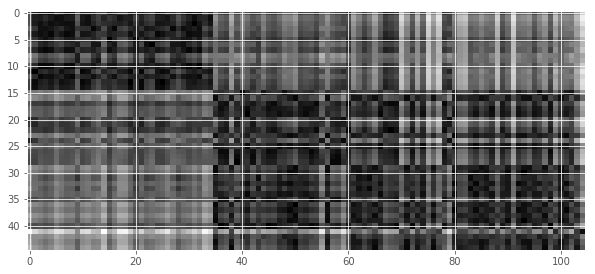

In [9]:
print dists.shape
# We can visualize the distance matrix: each row is a single test example and its distances to training examples",
plt.imshow(dists, interpolation='none')
plt.gray()
#here dark means less distance and light means high distance...

#### Optimization time
If you find spending too much time on these two steps skip them and come back later to speed up your implementation

In [11]:
from nose.tools import assert_less_equal
feat=[0,1]
knn=KNearestNeighbor(3)
knn.train(Xtrain[:,feat],Ytrain)

dists = knn.compute_distances_two_loops(Xtest[:,feat])
one_loop_dists = knn.compute_distances_one_loop(Xtest[:,feat])
no_loop_dists = knn.compute_distances_no_loops(Xtest[:,feat])

difference = np.linalg.norm(dists - one_loop_dists, ord='fro')
difference_1 = np.linalg.norm(dists - no_loop_dists, ord='fro')

assert_less_equal(difference, 0.001, "Two loops and one loop distance varies")
assert_less_equal(difference_1, 0.001, "Two loops and no loop distance varies")

/home/aqib/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt


AssertionError: Two loops and no loop distance varies

In [12]:
from nose.tools import assert_less_equal
import time

feat=[0,1]
knn=KNearestNeighbor(3)
knn.train(Xtrain[:,feat],Ytrain)

start = time.time()
knn.compute_distances_two_loops(Xtest[:,feat])
end = time.time()
two_loops = (end - start)
print "Two loops took : ",(end - start)

start = time.time()
one_loop = knn.compute_distances_one_loop(Xtest[:,feat])
end = time.time()
one_loop = (end - start)
print "One loops took : ",(end - start)

start = time.time()
no_loop = knn.compute_distances_no_loops(Xtest[:,feat])
end = time.time()
no_loop = (end - start)
print "No loops took  : ",(end - start)

assert_less_equal(one_loop, two_loops/10.0)
assert_less_equal(no_loop, one_loop)

Two loops took :  0.107277154922
One loops took :  0.00133395195007
No loops took  :  0.000404119491577


/home/aqib/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in sqrt


# Testing

In [13]:
#Lets test it on the set of unseen examples...
pclasses=knn.predict(Xtest[:,feat])

In [14]:
print pclasses

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-virginica'
 'Iris-versicolor' 'Iris-versicolor']


Lets see how good we are doing...
==================

In [15]:
#Lets see how good we are doing, by finding the accuracy on the test set..
print np.sum(pclasses==Ytest)
print "Accuracy = ", np.sum(pclasses==Ytest)/float(Ytest.shape[0])

34
Accuracy =  0.755555555556


In [16]:
from nose.tools import assert_greater_equal

eat=[0,1]
knn=KNearestNeighbor(3)
knn.train(Xtrain[:,feat],Ytrain)
pclasses=knn.predict(Xtest[:,feat])
acc = np.sum(pclasses==Ytest)/float(Ytest.shape[0])

assert_greater_equal(acc, 0.64)

In [18]:
from nose.tools import assert_greater_equal

feat=[0,1]
knn=KNearestNeighbor(3)
knn.train(Xtrain[:,feat],Ytrain)
pclasses=knn.predict(Xtest[:,feat])
acc = np.sum(pclasses==Ytest)/float(Ytest.shape[0])

assert_greater_equal(acc, 0.64)

 Plotting the Decision Surface of Training Set... 


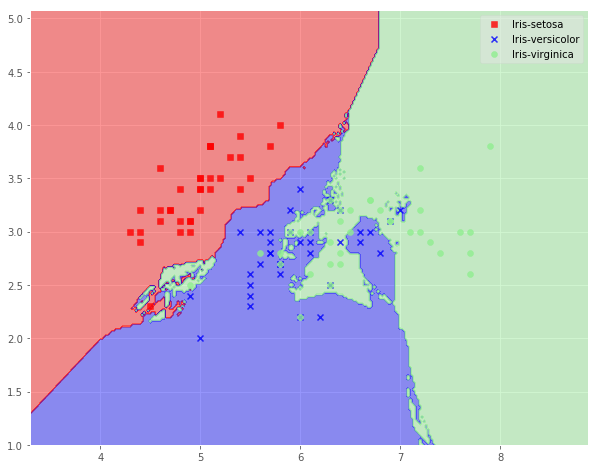

In [19]:
#Lets plot the decision surface
#%debug
print " Plotting the Decision Surface of Training Set... "
t.plot_decision_regions(Xtrain[:,feat],Ytrain,clf=knn, res=0.02, cycle_marker=True, legend=1)

 Plotting the Decision Surface of Test Set... 


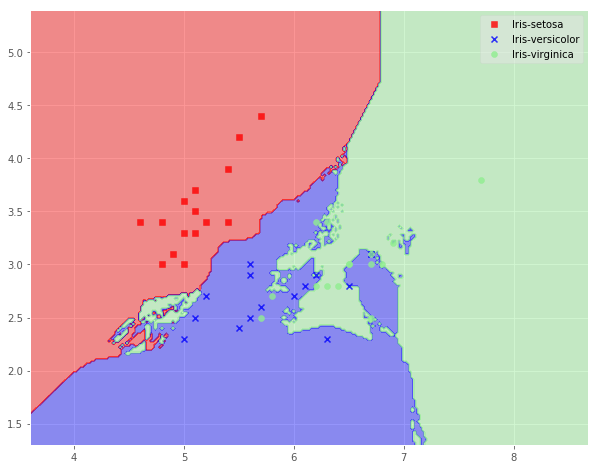

In [20]:
print " Plotting the Decision Surface of Test Set... "
t.plot_decision_regions(Xtest[:,feat],Ytest,clf=knn, res=0.02, cycle_marker=True, legend=1)

# Feature Scaling (or Normalization)

Since we are using Euclidean distance to find the nearest neighbours, which is (as we have seen in the lectures) is heavily influenced by differently scaled features (that features having different scales and ranges). So to make best of K Nearest Neigbhour classifier we will be needed to first scale each feature dimension. Now lets go and write code for the feature scaling in KNearestNeighbour...

 Plotting the Decision Surface of Test Set... 
CPU times: user 2min 4s, sys: 64 ms, total: 2min 4s
Wall time: 2min 4s


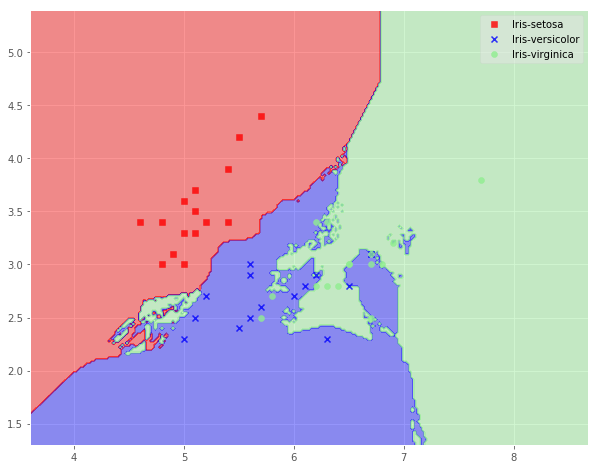

In [21]:
%%time
print " Plotting the Decision Surface of Test Set... "
t.plot_decision_regions(Xtest[:,feat],Ytest,clf=knn, res=0.02, cycle_marker=True, legend=1)

# Comment on the effect of feature scaling and normalization. 

What is the difference between the results of normalized features and non-normalized features. Why we are seeing the improvement (or decrease) in the accuracy.

# Lets Train on all four features....

In [22]:
#Lets Train on all four features....

# Lets train a Decision Tree Classifier on Petal Length and Width
feat=[0, 1, 2, 3]
knn=KNearestNeighbor(3)#
knn.train(Xtrain[:,feat],Ytrain)
pclasses=knn.predict(Xtest[:,feat], methodtype='twoloop')
#Lets see how good we are doing, by finding the accuracy on the test set..
print np.sum(pclasses==Ytest)
print "Accuracy = ", np.sum(pclasses==Ytest)/float(Ytest.shape[0])

44
Accuracy =  0.977777777778


In [23]:
from nose.tools import assert_greater_equal

feat=[0, 1, 2, 3]
knn=KNearestNeighbor(3)
knn.train(Xtrain[:,feat],Ytrain)
pclasses=knn.predict(Xtest[:,feat],  methodtype='twoloop')
acc = np.sum(pclasses==Ytest)/float(Ytest.shape[0])

assert_greater_equal(acc, 0.90)

What can you conclude ?
====================
Please write your observation....



# Cross-Validation

Until now we have been splitting the dataset into a training and test set rather randomly and were reporting a rather artifical performance. Now we are going to test our system exhaustively by making use of k-fold [cross validation](http://en.wikipedia.org/wiki/Cross-validation_%28statistics%29). 

Now go and tune your hyper-parameters (K in this case) to opitmize the performance for only first two parameters.

In [24]:
import time

In [27]:
# Now lets cross validate for best paramters, and test the result...
# We will be training four different models on four different partitions of data set and 
# then will be reporting the mean accuracy of the four classifiers.
stime=time.time()


nfolds=4 # lets use four folds..
folds=t.generate_folds(X,Y,nfolds)
features=[0,1] # features to use for our system
#now lets train and test on these folds...

#Lets perform the grid search...
ks=np.arange(1,20,2) # search the k in the range one to 20...
foldacc=[]

for i in range(0,len(ks)):
    total_acc=0
    tempacc=[]
    knn=KNearestNeighbor(ks[i])
    for j in range(0,nfolds):
        Xtrain_temp=folds[j][0]
        Ytrain_temp=folds[j][1]
        Xtest_temp= folds[j][2]
        knn.train(Xtrain_temp[:,features],Ytrain_temp)
        pclasses=knn.predict(Xtest_temp[:,features], methodtype='oneloop')
        total_acc=np.sum(pclasses==folds[j][3])/float(folds[j][3].shape[0]) 
        tempacc.append(total_acc)
        print '\t[Fold',str(j)+'] Accuracy = '+str(total_acc)
    z=np.mean(tempacc)
    print 'For K='+str(ks[i])+', Mean Accuracy = ',z
    foldacc.append(z)
indx=np.argmax(foldacc)
bestk =ks[indx]
print 'Best value for K='+str(bestk)+' and gives the following mean accuracy =',str(foldacc[indx])

Generating CV data for 3 classes
	[Fold 0] Accuracy = 0.694444444444
	[Fold 1] Accuracy = 0.722222222222
	[Fold 2] Accuracy = 0.638888888889
	[Fold 3] Accuracy = 0.805555555556
For K=1, Mean Accuracy =  0.715277777778
	[Fold 0] Accuracy = 0.638888888889
	[Fold 1] Accuracy = 0.694444444444
	[Fold 2] Accuracy = 0.777777777778
	[Fold 3] Accuracy = 0.777777777778
For K=3, Mean Accuracy =  0.722222222222
	[Fold 0] Accuracy = 0.638888888889
	[Fold 1] Accuracy = 0.75
	[Fold 2] Accuracy = 0.777777777778
	[Fold 3] Accuracy = 0.777777777778
For K=5, Mean Accuracy =  0.736111111111
	[Fold 0] Accuracy = 0.722222222222
	[Fold 1] Accuracy = 0.75
	[Fold 2] Accuracy = 0.777777777778
	[Fold 3] Accuracy = 0.805555555556
For K=7, Mean Accuracy =  0.763888888889
	[Fold 0] Accuracy = 0.722222222222
	[Fold 1] Accuracy = 0.722222222222
	[Fold 2] Accuracy = 0.805555555556
	[Fold 3] Accuracy = 0.805555555556
For K=9, Mean Accuracy =  0.763888888889
	[Fold 0] Accuracy = 0.75
	[Fold 1] Accuracy = 0.722222222222


Text(0.5,1,u'Cross Validation Accuracy for different Values of K')

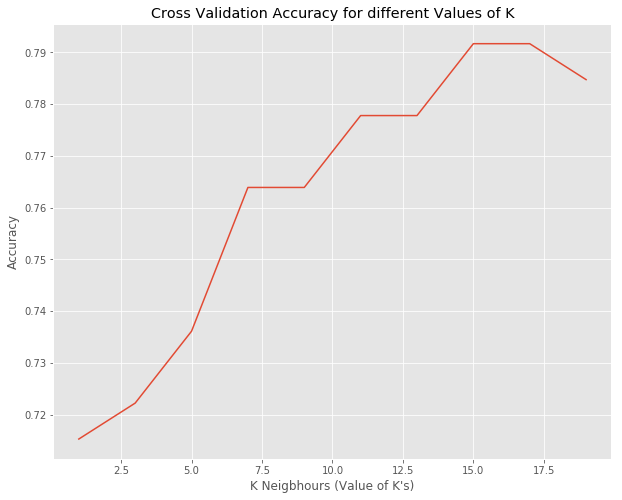

In [28]:
#Lets plot the accuracy w.r.t K
plt.plot(ks,foldacc)
plt.xlabel('K Neigbhours (Value of K\'s)')
plt.ylabel('Accuracy')
plt.title('Cross Validation Accuracy for different Values of K')

# Lets retrain the classifier with best-k and see its accuracy using only first two features...

In [29]:
print bestk

17


In [30]:
feat=[0,1]
knn=KNearestNeighbor(bestk,scalefeatures=True) # train a kbest-nearest neighbour classifier...
knn.train(Xtrain[:,feat],Ytrain)

#Lets test it on the set of unseen examples...
pclasses=knn.predict(Xtest[:,feat])
#Lets see how good we are doing, by finding the accuracy on the test set..
print np.sum(pclasses==Ytest)
print "KNN Accuracy (for best K={}) ={} ".format(bestk,np.sum(pclasses==Ytest)/float(Ytest.shape[0]))

37
KNN Accuracy (for best K=17) =0.822222222222 


 Plotting the Decision Surface of Test Set... 


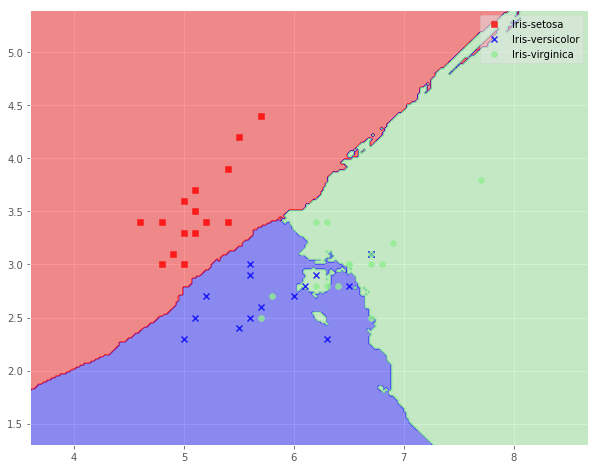

In [31]:
print " Plotting the Decision Surface of Test Set... "
t.plot_decision_regions(Xtest[:,feat],Ytest,clf=knn, res=0.02, cycle_marker=True, legend=1)

### Note the improvement of properly configured classifier w.r.t. to the classifier trained using only 3 Neigbours

Comment on your experience.